In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import yaml
from daart.data import DataGenerator, compute_sequence_pad
from daart.eval import get_precision_recall, run_lengths
from daart.io import get_expt_dir
from daart.transforms import ZScore

from daart_utils.data import DataHandler
from daart_utils.models import compute_model_predictions, get_default_hparams
#from daart_utils.paths import data_path, results_path
from daart_utils.plotting import plot_heatmaps
import ssm
from ssm.util import random_rotation, find_permutation

In [42]:
import torch
from daart.io import get_expt_dir, find_experiment
from daart.models import Segmenter, RSLDS

#from daart_utils.session_ids.fly import SESS_IDS_TRAIN_5, SESS_IDS_TEST
#from daart_utils.session_ids.fly import label_names
data_path = '/Users/blau/Projects/daart_utils/data/'
#ssm labels
label_names = ['right', 'left', 'top', 'bottom']

# save predicted states from models
save_states = True
# overwrite predicted states from models
overwrite_states = False
# compute state statistics like median bout duration and behavior ratios
compute_state_stats = False

dataset = 'ssm'
input_type = 'markers'
# input_type = 'features-simba'
sequence_length = 500
batch_size = 8
ignore_background = True
anneal_start = 25
anneal_end = 75


sess_ids_test = ['ssm_v1']
# load model



# fill out hparams
model_type = 'dtcn'
tt_expt_dir = 'test'
lambda_weak = 0
lambda_strong = 1
lambda_pred = 0

ss_algo = 'weak'  # 'weak' | 'pseudo_labels' | 'task'

# fill out hparams
backbone = 'dtcn'
model_class = 'rslds'
# tt_expt_dir = 'ssl_test2'  # fly, ibl
hparams = get_default_hparams(
    model_class=model_class, device='cuda', sequence_length=sequence_length, n_lags=4,
    input_type=input_type, backbone=backbone, batch_size=batch_size,
    anneal_start=25, anneal_end=75, prob_threshold=0.9,  # pseudo_labels params
)
hparams['sequence_pad'] = compute_sequence_pad(hparams)

#hparams['device'] = 'cuda'
hparams['device'] = 'cpu'

version_dir = "/Users/blau/Projects/daart/results_gmdgm/ssm_v1/dtcn/nc_v1/version_2" #os.path.join(hparams['tt_expt_dir'], version_str)
hdir = "/Users/blau/Projects/daart/results_gmdgm/ssm_v1/dtcn/rgt_v1/version_0"
model_file = os.path.join(version_dir, 'best_val_model.pt')
arch_file = os.path.join(hdir, 'hparams.yaml')
#arch_file = os.path.join(version_bdir, 'hparams.yaml')
print('Loading model defined in %s' % arch_file)
with open(arch_file, 'rb') as f:
    hparams_new = yaml.safe_load(f)
hparams_new['device'] = hparams.get('device', 'cpu')
model_0 = RSLDS(hparams_new)
model_0.load_state_dict(torch.load(
    model_file, map_location=lambda storage, loc: storage))
model_0.to(hparams_new['device'])
model_0.eval()

Loading model defined in /Users/blau/Projects/daart/results_gmdgm/ssm_v1/dtcn/rgt_v1/version_0/hparams.yaml


RSLDS(
  (model): ModuleDict(
    (qy_x): DilatedTCN(
      (model): Sequential(
        (tcn_block_00): DilationBlock(
          (conv0): Conv1d(10, 2, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
          (conv1): Conv1d(2, 2, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
          (activation): LeakyReLU(negative_slope=0.05)
          (final_activation): LeakyReLU(negative_slope=0.05)
          (dropout): Dropout2d(p=0.1, inplace=False)
          (block): Sequential(
            (conv1d_layer_0): Conv1d(10, 2, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
            (lrelu_0): LeakyReLU(negative_slope=0.05)
            (dropout_0): Dropout2d(p=0.1, inplace=False)
            (conv1d_layer_1): Conv1d(2, 2, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
            (lrelu_1): LeakyReLU(negative_slope=0.05)
            (dropout_1): Dropout2d(p=0.1, inplace=False)
          )
          (downsample): Conv1d(10, 2, kernel_size=(1,)

In [43]:
def confusion_matrix(true_states, inf_states, num_states):
    confusion = np.zeros((num_states, num_states))
    ztotal = np.zeros((num_states, 1))
    for i in range(num_states):
        for ztrue, zinf in zip(true_states, inf_states):
            for j in range(num_states):
                confusion[i, j] += np.sum((ztrue == i) & (zinf == j))
            ztotal[i] += np.sum(ztrue==i)
    return confusion / ztotal

In [44]:
states_hand = {}
state_overlaps_0 = {}
# state_overlaps_1 = {}
state_probs_0 = {}
# state_probs_1 = {}
states_0 = {}
# states_1 = {}
state_overlaps = {}
print((hparams['trial_splits']))

inferred_latents = []
for expt_id in sess_ids_test:
        
    print(expt_id)
    
    # initialize data handler; point to correct base path
    handler = DataHandler(expt_id, base_path=os.path.join(data_path, dataset))
    if input_type == 'markers':
        markers_file = handler.get_marker_filepath()
    else:
        markers_file = handler.get_feature_filepath(dirname=input_type)

    hand_labels_file = os.path.join(
                "/Users/blau/Projects/daart/data/", 'labels-hand', expt_id + '_labels.csv')

    # define data generator signals
    signals = ['markers', 'labels_strong']
    transforms = [ZScore(), None]
    paths = [markers_file, hand_labels_file]

    # build data generator
    data_gen_test = DataGenerator(
        [expt_id], [signals], [transforms], [paths], device=hparams['device'], 
        batch_size=hparams['batch_size'], trial_splits='1;1;0;0', 
        sequence_pad=hparams['sequence_pad'], sequence_length=hparams['sequence_length'],
        input_type=hparams['input_type'])
    print('----------------------------')
    print(data_gen_test)
    print('----------------------------')
    print('\n')

    # load hand labels
    handler.load_hand_labels()
    states = np.argmax(handler.hand_labels.vals, axis=1)
    cutoff = int(np.floor(states.shape[0] / hparams['batch_size'])) * hparams['batch_size']
    #states = states[:cutoff]
    states_hand[expt_id] = states
    
    # compute predictions
    print('computing predictions for model 0...', end='')
    tmp = model_0.predict_labels(data_gen_test, return_scores=True)
    labels_pred = np.vstack(tmp['qy_x_probs'][0])
    
    inferred_latents = np.vstack(tmp['qz_xy_mean'][0])
    yhat = np.vstack(tmp['qy_x_probs'][0])
    xhat = np.vstack(tmp['reconstruction'][0])
    x_gt = np.vstack(tmp['markers'][0])
    
    weights = tmp['pz_mean']
    labels_model_ = np.argmax(labels_pred, axis=1)
    probs_max = np.max(labels_pred, axis=1)
    labels_model = np.copy(labels_model_)
    # labels_model[probs_max < 0.75] = 0
    state_probs_0[expt_id] = labels_pred
    states_0[expt_id] = labels_model
    
    states = states[:len(labels_model)]
    states_hand[expt_id] = states
    
    state_overlaps_0[expt_id] = confusion_matrix(
        [states], [states_0[expt_id]], num_states=len(label_names))
    


9;1;0;0
ssm_v1
----------------------------
Generator contains 1 SingleDataset objects:
ssm_v1
    signals: ['markers', 'labels_strong']
    transforms: OrderedDict([('markers', ZScore()), ('labels_strong', None)])
    paths: OrderedDict([('markers', '/Users/blau/Projects/daart_utils/data/ssm/markers/ssm_v1_labeled.npy'), ('labels_strong', '/Users/blau/Projects/daart/data/labels-hand/ssm_v1_labels.csv')])

----------------------------


computing predictions for model 0...

In [45]:
states_all_hand = []
states_all_0 = []


for expt_id in sess_ids_test:
    s = states_hand[expt_id]
    states_all_hand.append(states_hand[expt_id])#[s > 0])
    states_all_0.append(states_0[expt_id])#[s > 0])
#     states_all_1.append(states_1[expt_id][s > 0])

state_overlaps_all_0 = confusion_matrix(
    states_all_hand, states_all_0, num_states=len(label_names))



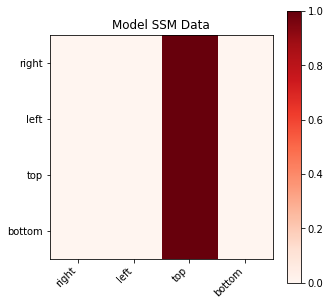

In [41]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(state_overlaps_all_0[:, :], vmin=0, vmax=1, cmap='Reds')#'Greys_r')
plt.title('Model SSM Data')
plt.yticks(np.arange(len(label_names)), label_names[:])
plt.xticks(np.arange(len(label_names)), label_names[:], rotation=45, ha='right')
plt.colorbar()
plt.show()

In [36]:
mse = x_gt - xhat
mse = np.mean(mse*mse, axis=1)
mse = np.mean(mse, axis=0)
print('recon mse', mse)

recon mse 0.02546548
